<a href="https://colab.research.google.com/github/uc2045/genai-projects/blob/master/030925_Conditional_Routing_in_LangGraph_March2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional Routing in LangGraph

In LangGraph, conditional routing allows the dynamic determination of the next node(s) to execute based on the current state.

This is achieved using conditional edges, which evaluate a function using certain defined logic, to decide the subsequent path in the graph.

This mechanism enables the creation of adaptable workflows that respond to varying conditions during execution. Let's dive deep into conditional routing in this demo.

![](https://i.imgur.com/uX12AyO.png)

## Install Dependencies

In [ ]:
!pip install langchain==0.3.19
!pip install langgraph==0.3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.5/131.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.0 MB/s eta 0:00:00


## Creating the Graph with Conditional Edges

[Edges](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges) connect the nodes.

Normal Edges are used if you want to *always* go from, for example, `node_1` to `node_2`.

[Conditional Edges](https://langchain-ai.github.io/langgraph/reference/graphs/?h=conditional+edge#langgraph.graph.StateGraph.add_conditional_edges) are used want to *optionally* route between nodes.

Conditional edges are implemented as functions that return the next node to visit based upon some logic.

![](https://i.imgur.com/uX12AyO.png)

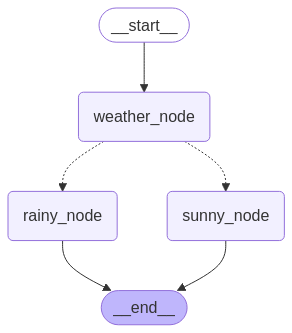

In [ ]:
from typing import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Define the state structure
class State(TypedDict):
    weather: str

# Initialize the StateGraph
graph_builder = StateGraph(State)

# Define node functions
def weather_node(state: State) -> State:
    print("\nChecking the weather...")
    # here you might want to call some tool or logic and get the weather
    # for now we will just pass the state along which has the weather key - value pair
    print('Weather key value is:', state)
    return state  # Just pass the state along

def rainy_node(state: State) -> State:
    print("It's rainy. Take an umbrella!")
    return state

def sunny_node(state: State) -> State:
    print("It's sunny. Wear sunglasses!")
    return state

# Define the routing function
def weather_routing(state: State) -> str:
    if state['weather'] == 'rainy':
        return "rainy_node" # name of the rainy node we will define shortly
    elif state['weather'] == 'sunny':
        return "sunny_node" # name of the sunny node we will define shortly
    else:
        raise ValueError("Invalid weather condition!")

# Add nodes to the graph
graph_builder.add_node("weather_node", weather_node)
graph_builder.add_node("rainy_node", rainy_node)
graph_builder.add_node("sunny_node", sunny_node)

# Define edges
graph_builder.add_edge(START, "weather_node")
graph_builder.add_conditional_edges("weather_node",
                                    # the routing function will route to rainy_node if weather state is 'rainy'
                                    # the routing function will route to sunny_node if the weather state is 'sunny'
                                    weather_routing, # routing function
                                    ["rainy_node", "sunny_node"] # possible nodes where the routing function can end up going
                                   )
graph_builder.add_edge("rainy_node", END)
graph_builder.add_edge("sunny_node", END)

# Compile the graph
graph = graph_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Execute the graph with an initial state for "rainy"
initial_state_rainy = {"weather": "rainy"}
result_rainy = graph.invoke(initial_state_rainy)


Checking the weather...
Weather key value is: {'weather': 'rainy'}
It's rainy. Take an umbrella!


In [ ]:
# Execute the graph with an initial state for "sunny"
initial_state_sunny = {"weather": "sunny"}
result_sunny = graph.invoke(initial_state_sunny)


Checking the weather...
Weather key value is: {'weather': 'sunny'}
It's sunny. Wear sunglasses!


In [ ]:
# Execute the graph with an initial state for "sunny"
initial_state_sunny = {"weather": "humid"}
result_sunny = graph.invoke(initial_state_sunny)


Checking the weather...
Weather key value is: {'weather': 'humid'}


ValueError: Invalid weather condition!

## Conditional Routing with More Nodes

The more nodes you have for custom logic you just need to define the node functions and then put in relevant conditions for the function which would do the conditional routing as shown in the example below.

![](https://i.imgur.com/FbiQBYZ.png)

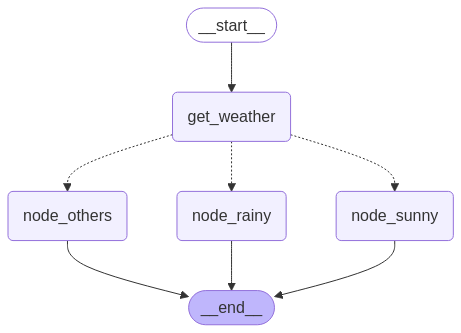

In [ ]:
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]
    weather: str


def get_weather(state: State) -> str:
    weather = state['messages'][0].content # extracting the content from user input
    print(f"---Getting weather: {weather}---")
    return {"weather": weather} # updates the weather state

def node_sunny(state):
    print("---Executing logic for Sunny Node---")
    weather = state['weather']
    return {"messages": "Looks like its " + weather + "! Drink enough water."}

def node_rainy(state):
    print("---Executing logic for Rainy Node---")
    weather = state['weather']
    return {"messages": "Looks like its " + weather + "! Take an umbrella."}

def node_others(state):
    print("---Executing logic for Rainy Node---")
    weather = state['weather']
    return {"messages": "Looks like its " + weather + "! I'm sorry I cannot help with that."}

def decide_route(state: State) -> State:
    print("---Conditional Routing Execution---")
    weather = state['weather']
    print('Weather key value is:', weather)
    # for more complex reasoning based routing
    # use an LLM to decide the node based on a prompt
    # that is typically known as LLM routing
    if weather.lower() in ['sunny', 'humid']:
        return "node_sunny"
    if weather.lower() in ['rainy', 'overcast']:
        return "node_rainy"
    return "node_others"

# Build graph
builder = StateGraph(State)
builder.add_node("get_weather", get_weather)
builder.add_node("node_sunny", node_sunny)
builder.add_node("node_rainy", node_rainy)
builder.add_node("node_others", node_others)

# Logic
builder.add_edge(START, "get_weather")
builder.add_conditional_edges("get_weather",
                              decide_route,
                              ["node_sunny", "node_rainy", "node_others"]
                              )
builder.add_edge("node_sunny", END)
builder.add_edge("node_rainy", END)
builder.add_edge("node_others", END)


# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
def call_agent(agent, topic):
    msgs = agent.invoke({"messages": topic})
    print(msgs['messages'][-1].content)


In [ ]:
call_agent(graph, "Sunny")

---Getting weather: Sunny---
---Conditional Routing Execution---
Weather key value is: Sunny
---Executing logic for Sunny Node---
Looks like its Sunny! Drink enough water.


In [ ]:
call_agent(graph, "overcast")

---Getting weather: overcast---
---Conditional Routing Execution---
Weather key value is: overcast
---Executing logic for Rainy Node---
Looks like its overcast! Take an umbrella.


In [ ]:
call_agent(graph, "Humid")

---Getting weather: Humid---
---Conditional Routing Execution---
Weather key value is: Humid
---Executing logic for Sunny Node---
Looks like its Humid! Drink enough water.


In [ ]:
call_agent(graph, "Stormy")

---Getting weather: Stormy---
---Conditional Routing Execution---
Weather key value is: Stormy
---Executing logic for Rainy Node---
Looks like its Stormy! I'm sorry I cannot help with that.
